# 实验一：基于卷积神经网络的花卉图像识别实验

## 实验介绍

随着电子技术的迅速发展，人们使用便携数码设备（如手机、相机等）获取花卉图像越来越方便，如何自动识别花卉种类受到了广泛的关注。由于花卉所处背景的复杂性，以及花卉自身的类间相似性和类内多样性，利用传统的手工提取特征进行图像分类的方法，并不能很好地解决花卉图像分类这一问题。　　　

本实验主要介绍如何使用MindSpore进行花卉图像分类实验。定义卷积神经网络，并利于该网络进行花卉分类训练和测试。

## 实验目的

- 掌握卷积网络相关基础知识点。
- 掌握使用MindSpore进行卷积神经网络开发的一般流程。
- 了解如何使用MindSpore进行花卉图片分类任务的训练和测试。
- 掌握使用t-sne实现对提取的特征进行可视化的能力

## 实验环境

- MindSpore 1.7.0

## 实验内容



In [1]:
%cd /home/ma-user/work

/home/ma-user/work


### 导入MindSpore及其他相关模块

In [3]:
#easydict模块用于以属性的方式访问字典的值
from easydict import EasyDict as edict
#glob模块主要用于查找符合特定规则的文件路径名，类似使用windows下的文件搜索
import glob
#os模块主要用于处理文件和目录
import os
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm
from sklearn.manifold import TSNE

import mindspore
#导入mindspore框架数据集
import mindspore.dataset as ds
#vision.c_transforms模块是处理图像增强的高性能模块，用于数据增强图像数据改进训练模型。
import mindspore.dataset.vision.c_transforms as CV
#c_transforms模块提供常用操作，包括OneHotOp和TypeCast
import mindspore.dataset.transforms.c_transforms as C
from mindspore.common import dtype as mstype
from mindspore import context
#导入模块用于初始化截断正态分布
from mindspore.common.initializer import TruncatedNormal
from mindspore import nn
from mindspore.train import Model
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
from mindspore.train.serialization import load_checkpoint, load_param_into_net
from mindspore import Tensor
# 设置MindSpore的执行模式和设备
context.set_context(mode=context.GRAPH_MODE, device_target="GPU")

### 变量定义


In [4]:
cfg = edict({
    'data_path': 'flower_photos',
    'data_size':3670,
    'image_width': 100,  # 图片宽度
    'image_height': 100,  # 图片高度
    'batch_size': 32,
    'channel': 3,  # 图片通道数
    'num_class':5,  # 分类类别
    'weight_decay': 0.01,
    'lr':0.0001,  # 学习率
    'epoch_size': 50,  # 训练次数
    'sigma':0.01,
    
    'save_checkpoint_steps': 1,  # 多少步保存一次模型
    'keep_checkpoint_max': 1,  # 最多保存多少个模型
    'output_directory': './',  # 保存模型路径
    'output_prefix': "checkpoint_classification"  # 保存模型文件名字
})

### 数据集介绍

该数据集是开源数据集，总共包括5种花的类型：分别是daisy（雏菊，633张），dandelion（蒲公英，898张），roses（玫瑰，641张），sunflowers（向日葵，699张），tulips（郁金香，799张），保存在5个文件夹当中，总共3670张，大小大概在230M左右。为了在模型部署上线之后进行测试，数据集在这里分成了flower_train和flower_test两部分。

下面的代码可实现下载数据集与数据集可视化

In [4]:
# 下载与解压数据集（仅需运行一次）
!wget https://ascend-professional-construction-dataset.obs.myhuaweicloud.com/deep-learning/flower_photos.zip 
!unzip flower_photos.zip

--2025-12-11 13:40:06--  https://ascend-professional-construction-dataset.obs.myhuaweicloud.com/deep-learning/flower_photos.zip
Resolving ascend-professional-construction-dataset.obs.myhuaweicloud.com (ascend-professional-construction-dataset.obs.myhuaweicloud.com)... 100.125.83.5, 100.125.76.5, 100.125.83.133
Connecting to ascend-professional-construction-dataset.obs.myhuaweicloud.com (ascend-professional-construction-dataset.obs.myhuaweicloud.com)|100.125.83.5|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 229618046 (219M) [application/zip]
Saving to: ‘flower_photos.zip’

flower_photos.zip   100%[===================>] 218.98M   131MB/s    in 1.7s    

2025-12-11 13:40:08 (131 MB/s) - ‘flower_photos.zip’ saved [229618046/229618046]

Archive:  flower_photos.zip
   creating: flower_photos/
   creating: flower_photos/daisy/
  inflating: flower_photos/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flower_photos/daisy/10140303196_b88d3d6cec.jpg  
  inflating: fl

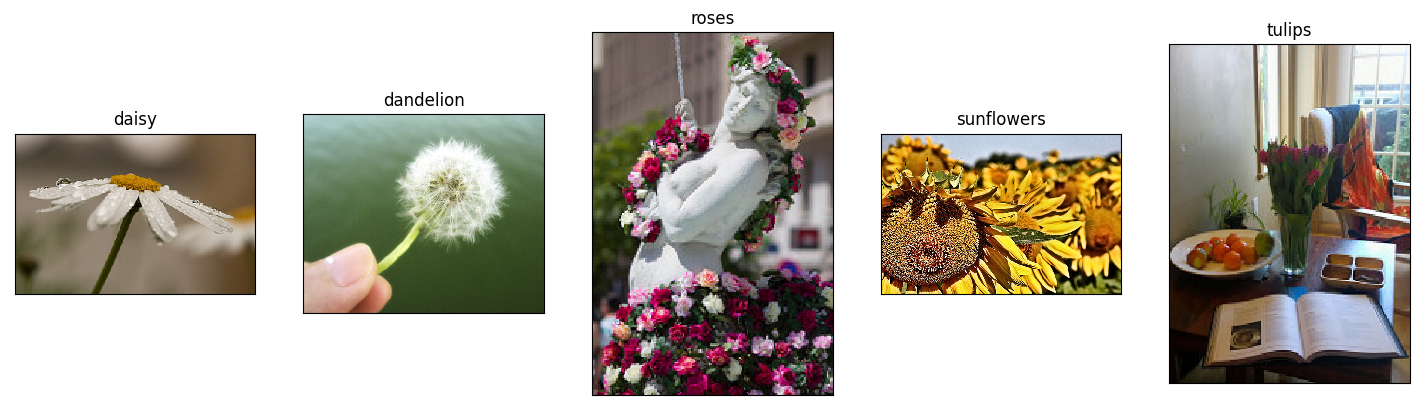

In [5]:
def no_axis_show(img, title='', cmap=None):
  # imshow, and set the interpolation mode to be "nearest"。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # do not show the axes in the images.
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

titles = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
plt.figure(figsize=(18, 18))
for i in range(5):
  plt.subplot(1, 5, i+1)
  paths = glob.glob(f'flower_photos/{titles[i]}/*.jpg')
  fig = no_axis_show(plt.imread(paths[random.randint(1, len(paths))]), title=titles[i])

### 读取并处理数据

数据读取并处理流程如下：

- MindSpore的mindspore.dataset提供了ImageFolderDatasetV2函数，可以直接读取文件夹图片数据并映射文件夹名字为其标签(label)。这里我们使用ImageFolderDatasetV2函数读取'daisy','dandelion','roses','sunflowers','tulips'数据。并将这五类标签映射为：{'daisy':0,'dandelion':1,'roses':2,'sunflowers':3,'tulips':4}
- 使用RandomCropDecodeResize、HWC2CHW、TypeCast、shuffle进行数据预处理
- 按照8:2的比列将数据划分为训练数据集和测试数据集
- 对训练数据和测试数据分批次（batch）

[WARNING] ME(100273:139651895568192,MainProcess):2025-12-11-15:44:08.358.819 [mindspore/dataset/engine/datasets.py:1122] Dataset is shuffled before split.


训练数据集数量： 2912
测试数据集数量： 23488
通道数/图像长/宽： (3, 100, 100)
一张图像的标签样式： 4


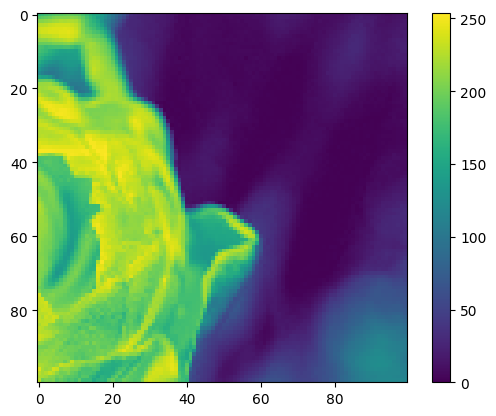

In [7]:
#从目录中读取图像的源数据集。
de_dataset = ds.ImageFolderDataset(cfg.data_path,
                                   class_indexing={'daisy':0,'dandelion':1,'roses':2,'sunflowers':3,'tulips':4})
#解码前将输入图像裁剪成任意大小和宽高比。
transform_img = CV.RandomCropDecodeResize([cfg.image_width,cfg.image_height], scale=(0.08, 1.0), ratio=(0.75, 1.333))  #改变尺寸
#转换输入图像；形状（H, W, C）为形状（C, H, W）。
hwc2chw_op = CV.HWC2CHW()
#转换为给定MindSpore数据类型的Tensor操作。
type_cast_op = C.TypeCast(mstype.float32)
#将操作中的每个操作应用到此数据集。
de_dataset = de_dataset.map(input_columns="image", num_parallel_workers=8, operations=transform_img)
de_dataset = de_dataset.map(input_columns="image", operations=hwc2chw_op, num_parallel_workers=8)
de_dataset = de_dataset.map(input_columns="image", operations=type_cast_op, num_parallel_workers=8)
de_dataset = de_dataset.shuffle(buffer_size=cfg.data_size)
#划分训练集测试集
(de_train,de_test)=de_dataset.split([0.8,0.2])
#设置每个批处理的行数
#drop_remainder确定是否删除最后一个可能不完整的批（default=False）。
#如果为True，并且如果可用于生成最后一个批的batch_size行小于batch_size行，则这些行将被删除，并且不会传播到子节点。
de_train=de_train.batch(cfg.batch_size, drop_remainder=True)
#重复此数据集计数次数。
de_test=de_test.batch(1, drop_remainder=True)
print('训练数据集数量：',de_train.get_dataset_size()*cfg.batch_size)#get_dataset_size()获取批处理的大小。
print('测试数据集数量：',de_test.get_dataset_size()*cfg.batch_size)

data_next=de_dataset.create_dict_iterator(output_numpy=True).__next__()
print('通道数/图像长/宽：', data_next['image'].shape)
print('一张图像的标签样式：', data_next['label'])  # 一共5类，用0-4的数字表达类别。

plt.figure()
plt.imshow(data_next['image'][0,...])
plt.colorbar()
plt.grid(False)
plt.show()

### 定义模型

![网络结构](http://picbed.rubbishman.xyz/202312171708310.png)

In [8]:
# 定义CNN图像识别网络
class Identification_Net(nn.Cell):
    def __init__(self, num_class=5,channel=3,trun_sigma=0.01):  # 一共分五类，图片通道数是3
        super(Identification_Net, self).__init__()
        self.num_class = num_class
        self.channel = channel
        #设置卷积层
        self.conv1 = nn.Conv2d(self.channel, 32,
                               kernel_size=5, stride=1, padding=0,
                               has_bias=True, pad_mode="same",
                               weight_init=TruncatedNormal(sigma=trun_sigma),bias_init='zeros')
        #设置ReLU激活函数
        self.relu = nn.ReLU()
        #设置最大池化层
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2,pad_mode="valid")
        self.conv2 = nn.Conv2d(32, 64,
                               kernel_size=5, stride=1, padding=0,
                               has_bias=True, pad_mode="same",
                               weight_init=TruncatedNormal(sigma=trun_sigma),bias_init='zeros')
        self.conv3 = nn.Conv2d(64, 128,
                               kernel_size=3, stride=1, padding=0,
                               has_bias=True, pad_mode="same",
                               weight_init=TruncatedNormal(sigma=trun_sigma),bias_init='zeros')
        self.conv4 = nn.Conv2d(128, 128,
                               kernel_size=3, stride=1, padding=0,
                               has_bias=True, pad_mode="same",
                               weight_init=TruncatedNormal(sigma=trun_sigma), bias_init='zeros')
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(6*6*128, 1024,weight_init =TruncatedNormal(sigma=trun_sigma),bias_init = 0.1)
        self.fc2 = nn.Dense(1024, 512, weight_init=TruncatedNormal(sigma=trun_sigma), bias_init=0.1)
        self.fc3 = nn.Dense(512, self.num_class, weight_init=TruncatedNormal(sigma=trun_sigma), bias_init=0.1)
        self.cell_out = []
    #构建模型
    def construct(self, x):
        x = self.conv1(x)
        #print(x.shape)
        x = self.relu(x)
        x = self.max_pool2d(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)

        x = self.conv3(x)
        x = self.max_pool2d(x)

        x = self.conv4(x)
        x = self.max_pool2d(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

❗任务一

完成模型训练，粘上运行结果Acc与测试集个别图像的预测结果（若结果不佳，可尝试增加训练的轮数）

### 模型训练Train与测试Val


In [8]:
net=Identification_Net(num_class=cfg.num_class, channel=cfg.channel)
#计算softmax交叉熵。
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
#opt
fc_weight_params = list(filter(lambda x: 'fc' in x.name and 'weight' in x.name, net.trainable_params()))
other_params=list(filter(lambda x: 'fc' not in x.name or 'weight' not in x.name, net.trainable_params()))
group_params = [{'params': fc_weight_params, 'weight_decay': cfg.weight_decay},
                {'params': other_params},
                {'order_params': net.trainable_params()}]
#设置Adam优化器
net_opt = nn.Adam(group_params, learning_rate=cfg.lr, weight_decay=0.0)
#net_opt = nn.Adam(params=net.trainable_params(), learning_rate=cfg.lr, weight_decay=0.1)

model = Model(net, loss_fn=net_loss, optimizer=net_opt, metrics={"acc"})
loss_cb = LossMonitor(per_print_times=10)
config_ck = CheckpointConfig(save_checkpoint_steps=cfg.save_checkpoint_steps,
                             keep_checkpoint_max=cfg.keep_checkpoint_max)
ckpoint_cb = ModelCheckpoint(prefix=cfg.output_prefix, directory=cfg.output_directory, config=config_ck)
print("============== Starting Training ==============")
model.train(cfg.epoch_size, de_train, callbacks=[loss_cb, ckpoint_cb], dataset_sink_mode=True)

# 使用测试集评估模型，打印总体准确率
metric = model.eval(de_test)
print(metric)

============== Starting Training ==============
epoch: 1 step: 91, loss is 1.3374123573303223
epoch: 2 step: 91, loss is 1.1538764238357544
epoch: 3 step: 91, loss is 1.4799094200134277
epoch: 4 step: 91, loss is 1.1485472917556763
epoch: 5 step: 91, loss is 1.1736962795257568
epoch: 6 step: 91, loss is 1.136436939239502
epoch: 7 step: 91, loss is 0.8928350806236267
epoch: 8 step: 91, loss is 0.8619248867034912
epoch: 9 step: 91, loss is 1.1891133785247803
epoch: 10 step: 91, loss is 1.0056391954421997
epoch: 11 step: 91, loss is 0.9445726871490479
epoch: 12 step: 91, loss is 0.9719346761703491
epoch: 13 step: 91, loss is 0.9354722499847412
epoch: 14 step: 91, loss is 0.7702749371528625
epoch: 15 step: 91, loss is 0.7434817552566528
epoch: 16 step: 91, loss is 0.5766544938087463
epoch: 17 step: 91, loss is 0.9786567687988281
epoch: 18 step: 91, loss is 1.2287373542785645
epoch: 19 step: 91, loss is 1.0065581798553467
epoch: 20 step: 91, loss is 1.0165908336639404
epoch: 21 step: 91, lo

### 模型预测Inference

使用pandas将测试集预测结果保存至csv文件中

In [9]:
# 加载模型
CKPT = os.path.join(cfg.output_directory,cfg.output_prefix+'-'+str(cfg.epoch_size)+'_'+str(de_train.get_dataset_size())+'.ckpt')
net = Identification_Net(num_class=cfg.num_class, channel=cfg.channel)
load_checkpoint(CKPT, net=net)
model = Model(net)

In [10]:
# 预测
class_names = {0:'daisy',1:'dandelion',2:'roses',3:'sunflowers',4:'tulips'}

predictions = np.array([])
labels = np.array([])

for test_ in de_test.create_dict_iterator():
    test = Tensor(test_['image'], mindspore.float32)
    prediction = model.predict(test)
    prediction = prediction.asnumpy()
    true_label = test_['label'].asnumpy()

    predictions = np.append(predictions, prediction)
    labels = np.append(labels, true_label)

predictions = np.argmax(predictions.reshape((-1, 5)), axis=1)
labels = labels.astype(int)

In [11]:
# 使用pandas生成csv
df = pd.DataFrame({'predictions': predictions, 'labels': labels})
df.to_csv('./results.csv', encoding='utf_8', index=False)

In [12]:
df

,predictions,labels
0,4,4
1,4,4
2,1,1
3,4,4
4,1,1
...,...,...
729,2,2
730,4,4
731,3,3
732,0,0


❗任务二

分别输出高级特征与中级特征的t-sne可视化图，并附上简单的解释

![t-sne可视化图样例](http://picbed.rubbishman.xyz/202312182020412.png)

### t-sne可视化

t-SNE（t-DistributedStochastic Neighbor Embedding，T 分布随机近邻嵌入）是一种可以把高维数据降到二维或三维的降维技术。我们使用t-sne来可视化提取到的特征的分布

In [11]:
# 定义CNN图像识别网络
class Identification_Net(nn.Cell):
    def __init__(self, num_class=5,channel=3,trun_sigma=0.01):  # 一共分五类，图片通道数是3
        super(Identification_Net, self).__init__()
        self.num_class = num_class
        self.channel = channel
        #设置卷积层
        self.conv1 = nn.Conv2d(self.channel, 32,
                               kernel_size=5, stride=1, padding=0,
                               has_bias=True, pad_mode="same",
                               weight_init=TruncatedNormal(sigma=trun_sigma),bias_init='zeros')
        #设置ReLU激活函数
        self.relu = nn.ReLU()
        #设置最大池化层
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2,pad_mode="valid")
        self.conv2 = nn.Conv2d(32, 64,
                               kernel_size=5, stride=1, padding=0,
                               has_bias=True, pad_mode="same",
                               weight_init=TruncatedNormal(sigma=trun_sigma),bias_init='zeros')
        self.conv3 = nn.Conv2d(64, 128,
                               kernel_size=3, stride=1, padding=0,
                               has_bias=True, pad_mode="same",
                               weight_init=TruncatedNormal(sigma=trun_sigma),bias_init='zeros')
        self.conv4 = nn.Conv2d(128, 128,
                               kernel_size=3, stride=1, padding=0,
                               has_bias=True, pad_mode="same",
                               weight_init=TruncatedNormal(sigma=trun_sigma), bias_init='zeros')
        self.flatten = nn.Flatten()
        self.fc1 = nn.Dense(6*6*128, 1024,weight_init =TruncatedNormal(sigma=trun_sigma),bias_init = 0.1)
        self.fc2 = nn.Dense(1024, 512, weight_init=TruncatedNormal(sigma=trun_sigma), bias_init=0.1)
        self.fc3 = nn.Dense(512, self.num_class, weight_init=TruncatedNormal(sigma=trun_sigma), bias_init=0.1)
    #构建模型
    def construct(self, x):
        cell_out = []

        x = self.conv1(x)
        cell_out.append(x)
        #print(x.shape)
        x = self.relu(x)
        cell_out.append(x)
        x = self.max_pool2d(x)
        cell_out.append(x)

        x = self.conv2(x)
        cell_out.append(x)
        x = self.relu(x)
        cell_out.append(x)
        x = self.max_pool2d(x)
        cell_out.append(x)

        x = self.conv3(x)
        cell_out.append(x)
        x = self.max_pool2d(x)
        cell_out.append(x)

        x = self.conv4(x)
        cell_out.append(x)
        x = self.max_pool2d(x)
        cell_out.append(x)
        
        x = self.flatten(x)
        cell_out.append(x)
        x = self.fc1(x)
        cell_out.append(x)
        x = self.relu(x)
        cell_out.append(x)
        x = self.fc2(x)
        cell_out.append(x)
        x = self.relu(x)
        cell_out.append(x)
        x = self.fc3(x)
        cell_out.append(x)
        return x, cell_out

In [12]:
# 加载模型
CKPT = os.path.join(cfg.output_directory,cfg.output_prefix+'-'+str(cfg.epoch_size)+'_'+str(de_train.get_dataset_size())+'.ckpt')
eval_net = Identification_Net(num_class=cfg.num_class, channel=cfg.channel)
load_checkpoint(CKPT, net=eval_net)
# model = Model(net)

eval_net.set_train(False)

Identification_Net<
  (conv1): Conv2d<input_channels=3, output_channels=32, kernel_size=(5, 5), stride=(1, 1), pad_mode=same, padding=0, dilation=(1, 1), group=1, has_bias=True, weight_init=<mindspore.common.initializer.TruncatedNormal object at 0x7f020c51aa50>, bias_init=zeros, format=NCHW>
  (relu): ReLU<>
  (max_pool2d): MaxPool2d<kernel_size=2, stride=2, pad_mode=VALID>
  (conv2): Conv2d<input_channels=32, output_channels=64, kernel_size=(5, 5), stride=(1, 1), pad_mode=same, padding=0, dilation=(1, 1), group=1, has_bias=True, weight_init=<mindspore.common.initializer.TruncatedNormal object at 0x7f024834b750>, bias_init=zeros, format=NCHW>
  (conv3): Conv2d<input_channels=64, output_channels=128, kernel_size=(3, 3), stride=(1, 1), pad_mode=same, padding=0, dilation=(1, 1), group=1, has_bias=True, weight_init=<mindspore.common.initializer.TruncatedNormal object at 0x7f020c5d7250>, bias_init=zeros, format=NCHW>
  (conv4): Conv2d<input_channels=128, output_channels=128, kernel_size=(3,

模型结构：

```
(0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
```

In [13]:
# Extract the representations for the specific layer of model
index = (3) # 你需要在模型结构中找到高级和中级特征所代表的层级的index并填在这里
features = []
labels = []

for batch in tqdm(de_test.create_tuple_iterator()):
    imgs, lbls = batch
    _, cell_out = eval_net(imgs)
    logits = cell_out[index]
    
    logits = logits.view(logits.shape[0], -1).asnumpy()
    
    labels.extend(lbls.asnumpy())
    features.extend(logits)

features = np.array(features)

features.shape

734it [00:03, 188.20it/s]


(734, 160000)

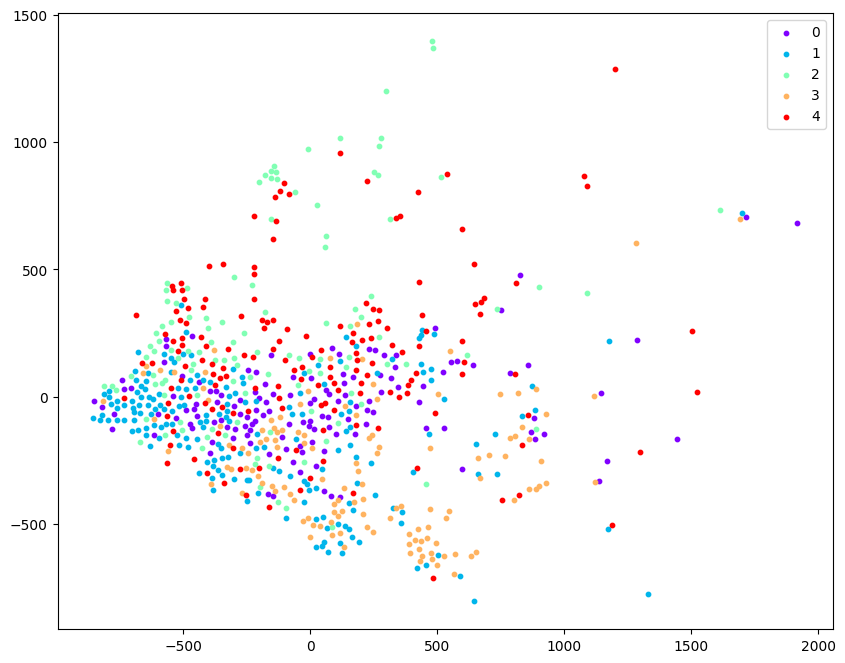

In [15]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# 1) 下采样：最多抽 2000 个点
N = features.shape[0]
max_points = 2000
if N > max_points:
    idx = np.random.choice(N, max_points, replace=False)
    features_sub = features[idx]
    labels_sub = labels[idx]
else:
    features_sub = features
    labels_sub = labels

# 2) 先 PCA 到 50 维
pca = PCA(n_components=50, random_state=42)
features_pca = pca.fit_transform(features_sub)

# 3) 再做 t-SNE（维度低了很多，会快很多）
features_tsne = TSNE(
    n_components=2,
    init='pca',
    random_state=42,
    n_iter=500,
    perplexity=20,   # 可以试 20 / 30 / 40
).fit_transform(features_pca)

# 4) 画图
colors_per_class = cm.rainbow(np.linspace(0, 1, len(np.unique(labels_sub))))
plt.figure(figsize=(10, 8))
for i, label in enumerate(np.unique(labels_sub)):
    plt.scatter(
        features_tsne[labels_sub == label, 0],
        features_tsne[labels_sub == label, 1],
        label=label, s=10, c=[colors_per_class[i]]
    )
plt.legend()
plt.show()


❗任务三

在原来模型结构的基础上，参考下图，增加残差连接。附上修改后的模型构建代码与结果Acc

![加入残差结构后模型结构图](http://picbed.rubbishman.xyz/202312181307468.png)

注：

- 下采样可使用1x1卷积+batchNorm层，使用`nn.SequentialCell`进行连接
- [nn.SequentialCell](https://www.mindspore.cn/docs/zh-CN/r1.7/api_python/nn/mindspore.nn.SequentialCell.html?highlight=sequentialcell#mindspore.nn.SequentialCell)
- [conv2d](https://www.mindspore.cn/docs/zh-CN/r1.7/api_python/nn/mindspore.nn.Conv2d.html?highlight=conv#mindspore.nn.Conv2d)
- [batchNorm](https://www.mindspore.cn/docs/zh-CN/r1.7/api_python/nn/mindspore.nn.BatchNorm2d.html?highlight=batchnorm#mindspore.nn.BatchNorm2d)

In [5]:
from mindspore import nn
from mindspore.common.initializer import TruncatedNormal

from mindspore import nn, ops
from mindspore.common.initializer import TruncatedNormal


from mindspore import nn, ops
from mindspore.common.initializer import TruncatedNormal


class SEBlock(nn.Cell):
    """Squeeze-and-Excitation 通道注意力"""
    def __init__(self, channel, reduction=16, trun_sigma=0.01):
        super(SEBlock, self).__init__()
        # 用 ReduceMean 在 (H,W) 维度上做全局平均
        self.mean = ops.ReduceMean(keep_dims=False)

        mid_ch = max(channel // reduction, 4)
        self.fc1 = nn.Dense(channel, mid_ch,
                            weight_init=TruncatedNormal(sigma=trun_sigma),
                            bias_init=0.0)
        self.fc2 = nn.Dense(mid_ch, channel,
                            weight_init=TruncatedNormal(sigma=trun_sigma),
                            bias_init=0.0)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def construct(self, x):
        # x: [B, C, H, W]
        b, c, _, _ = x.shape
        # 在 H、W 上取平均 -> [B, C]
        y = self.mean(x, (2, 3))
        y = self.fc1(y)
        y = self.relu(y)
        y = self.fc2(y)
        y = self.sigmoid(y)          # [B, C]
        y = y.view(b, c, 1, 1)       # 变回 [B, C, 1, 1] 方便广播
        return x * y                 # 通道加权




class ResidualBlock(nn.Cell):
    """带下采样 + SE 注意力的残差块"""
    def __init__(self, in_ch, out_ch, kernel_size, stride=1,
                 trun_sigma=0.01, use_se=True):
        super(ResidualBlock, self).__init__()
        # 主分支卷积
        self.conv = nn.Conv2d(in_ch, out_ch,
                              kernel_size=kernel_size,
                              stride=stride,
                              pad_mode="same",
                              has_bias=False,
                              weight_init=TruncatedNormal(sigma=trun_sigma))
        self.bn = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

        # 注意力
        self.use_se = use_se
        if use_se:
            self.se = SEBlock(out_ch, reduction=16, trun_sigma=trun_sigma)

        # 捷径分支：1×1 conv + BN，用于通道/下采样对齐
        if stride != 1 or in_ch != out_ch:
            self.downsample = nn.SequentialCell([
                nn.Conv2d(in_ch, out_ch,
                          kernel_size=1,
                          stride=stride,
                          pad_mode="same",
                          has_bias=False,
                          weight_init=TruncatedNormal(sigma=trun_sigma)),
                nn.BatchNorm2d(out_ch)
            ])
        else:
            self.downsample = None

    def construct(self, x):
        identity = x

        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)

        if self.use_se:
            out = self.se(out)       # ★ 通道注意力

        if self.downsample is not None:
            identity = self.downsample(identity)

        out = out + identity         # 残差相加
        out = self.relu(out)
        return out



class Identification_Net(nn.Cell):
    def __init__(self, num_class=5, channel=3, trun_sigma=0.01,use_se
                =True):
        super(Identification_Net, self).__init__()
        self.num_class = num_class
        self.channel = channel

        # 4 个 stage，每个 stage 用一个残差块，
        # stride=2 对应原来的 maxpool 下采样
        self.block1 = ResidualBlock(channel, 32, kernel_size=5,
                                    stride=2, trun_sigma=trun_sigma,use_se=use_se)
        self.block2 = ResidualBlock(32, 64, kernel_size=5,
                                    stride=2, trun_sigma=trun_sigma,use_se=use_se)
        self.block3 = ResidualBlock(64, 128, kernel_size=3,
                                    stride=2, trun_sigma=trun_sigma,use_se=use_se)
        self.block4 = ResidualBlock(128, 128, kernel_size=3,
                                    stride=2, trun_sigma=trun_sigma,use_se=use_se)

        self.flatten = nn.Flatten()
        # 这里仍然假设输入是 96×96，4 次 stride=2 之后就是 6×6
        self.fc1 = nn.Dense(7 * 7 * 128, 1024,
                            weight_init=TruncatedNormal(sigma=trun_sigma),
                            bias_init=0.1)
        self.fc2 = nn.Dense(1024, 512,
                            weight_init=TruncatedNormal(sigma=trun_sigma),
                            bias_init=0.1)
        self.fc3 = nn.Dense(512, self.num_class,
                            weight_init=TruncatedNormal(sigma=trun_sigma),
                            bias_init=0.1)
        self.relu = nn.ReLU()

    def construct(self, x):
        # 卷积 + 残差 + 1×1conv+BN 下采样 都在 block 里完成
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


In [8]:

net=Identification_Net(num_class=cfg.num_class, channel=cfg.channel,use_se=True)
#计算softmax交叉熵。
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
#opt
fc_weight_params = list(filter(lambda x: 'fc' in x.name and 'weight' in x.name, net.trainable_params()))
other_params=list(filter(lambda x: 'fc' not in x.name or 'weight' not in x.name, net.trainable_params()))
group_params = [{'params': fc_weight_params, 'weight_decay': cfg.weight_decay},
                {'params': other_params},
                {'order_params': net.trainable_params()}]
#设置Adam优化器
net_opt = nn.Adam(group_params, learning_rate=cfg.lr, weight_decay=0.0)
#net_opt = nn.Adam(params=net.trainable_params(), learning_rate=cfg.lr, weight_decay=0.1)

model = Model(net, loss_fn=net_loss, optimizer=net_opt, metrics={"acc"})
loss_cb = LossMonitor(per_print_times=10)
config_ck = CheckpointConfig(save_checkpoint_steps=cfg.save_checkpoint_steps,
                             keep_checkpoint_max=cfg.keep_checkpoint_max)
ckpoint_cb = ModelCheckpoint(prefix='checkpoint_res', directory=cfg.output_directory, config=config_ck)
print("============== Starting Training ==============")
model.train(cfg.epoch_size, de_train, callbacks=[loss_cb, ckpoint_cb], dataset_sink_mode=True)

# 使用测试集评估模型，打印总体准确率
metric = model.eval(de_test)
print(metric)

============== Starting Training ==============
epoch: 1 step: 91, loss is 1.2289608716964722
epoch: 2 step: 91, loss is 1.2735952138900757
epoch: 3 step: 91, loss is 1.0446534156799316
epoch: 4 step: 91, loss is 1.0675667524337769
epoch: 5 step: 91, loss is 0.7836048007011414
epoch: 6 step: 91, loss is 1.3320926427841187
epoch: 7 step: 91, loss is 0.7610524296760559
epoch: 8 step: 91, loss is 1.1014102697372437
epoch: 9 step: 91, loss is 0.6530309915542603
epoch: 10 step: 91, loss is 1.0070199966430664
epoch: 11 step: 91, loss is 1.001755952835083
epoch: 12 step: 91, loss is 0.8085755705833435
epoch: 13 step: 91, loss is 0.7452968955039978
epoch: 14 step: 91, loss is 0.9079552888870239
epoch: 15 step: 91, loss is 0.9242430925369263
epoch: 16 step: 91, loss is 0.8251878619194031
epoch: 17 step: 91, loss is 0.7780646681785583
epoch: 18 step: 91, loss is 0.9184733033180237
epoch: 19 step: 91, loss is 0.6832970380783081
epoch: 20 step: 91, loss is 0.6971011161804199
epoch: 21 step: 91, lo

## 实验结果与分析（20'）

### 任务一（5'）

完成模型训练，**在实验报告中记录**运行结果Acc与测试集个别图像的预测结果（若结果不佳，可尝试增加训练的轮数）

### 任务二（10'）

分别输出高级特征与中级特征的t-sne可视化图，将其**粘贴至实验报告中，尝试分析**下两张图的不同，以及不同的原因

![t-sne可视化图样例](http://picbed.rubbishman.xyz/202312182020412.png)

### 任务三（5'）

在原来模型结构的基础上，参考下图，增加残差连接。**在实验报告中粘贴**修改后的模型构建代码与结果Acc